# 1-S10: Transformer for Tabular Data

정형(Tabular) 데이터에 Transformer를 적용하는 방법을 학습합니다.

---

## 🎯 왜 Transformer를 배우나?

**현실:** 우리는 이미 XGBoost로 AUC 0.92를 달성했습니다!

그런데 왜 Transformer를 배울까요?

1. **면접 대비**: "Transformer 써봤어요?" 질문 대비
2. **트렌드 이해**: 2024-2025년 가장 핫한 딥러닝 아키텍처
3. **한계 인식**: 언제 Transformer가 좋고, 언제 트리가 좋은지 알기

> **결론 미리보기**: 정형 데이터에서는 **트리(XGBoost)가 아직 더 좋습니다!**
> 하지만 Transformer가 뭔지는 알아야 합니다.

---

## 📋 사전 지식

이 노트북을 이해하려면:
- ✅ Python 기초 (함수, 클래스)
- ✅ PyTorch 기초 (텐서, nn.Module) - 몰라도 주석으로 설명
- ✅ 딥러닝 기초 (뉴럴네트워크 개념) - 몰라도 OK

**처음 보는 용어가 나오면?** → 주석과 비유로 설명합니다!

---

## 학습 목표

| 순서 | 주제 | 난이도 |
|------|------|--------|
| 0 | 임베딩이란? | ⭐ 쉬움 |
| 1 | Self-Attention 개념 | ⭐⭐ 보통 |
| 2 | 정형 데이터에서 Transformer | ⭐⭐ 보통 |
| 3 | TabTransformer 구조 | ⭐⭐⭐ 어려움 (개념만) |
| 4 | FT-Transformer 구조 | ⭐⭐⭐ 어려움 (개념만) |
| 5 | 트리 vs Transformer | ⭐ 쉬움 |

---

## 결론 (먼저 알려드립니다!)

| 모델 | 장점 | 단점 | FDS에서? |
|------|------|------|----------|
| 트리 (XGBoost) | 빠름, 해석 가능 | 피처 간 관계 제한 | ✅ **채택** |
| Transformer | 피처 간 관계 학습 | 느림, 데이터 많이 필요 | ❌ 실험만 |

**왜 트리를 선택했나?**
1. 추론 속도: 5ms vs 50ms+
2. 해석 가능성: SHAP 지원
3. 성능: 59만 건에서 충분히 좋음

## 예상 시간
약 40분 (초보자 기준)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 로드 완료!")
print(f"PyTorch 버전: {torch.__version__}")
print(f"GPU 사용 가능: {torch.cuda.is_available()}")

패키지 로드 완료!
PyTorch 버전: 2.5.1
GPU 사용 가능: True


---
## 1. Self-Attention 기초

### 1-1. Attention이란?

**한 문장 요약:** "어떤 정보에 집중할지 자동으로 학습"

### 비유 1: 시험 공부

```
시험 범위: [1장, 2장, 3장, 4장, 5장]

선생님 힌트: "4장이 중요해요"
→ 당신의 Attention: [0.1, 0.1, 0.1, 0.6, 0.1]
                     ↑ 4장에 집중!
```

### 비유 2: 카페에서 주문 🍰

이게 Attention의 핵심입니다!

```
상황: 배고프고 달달한 게 땡김

메뉴판:
- 아메리카노 (쓴맛)
- 라떼 (부드러움)
- 케이크 (달콤함)      ← 이거!
- 샌드위치 (든든함)

당신의 Attention:
[0.05, 0.15, 0.70, 0.10]
       ↑ 케이크에 70% 집중!
```

**Attention = 각 항목에 "중요도 점수" 매기기**

---

### 1-2. Query, Key, Value (Q, K, V)

이게 제일 헷갈리는 부분! 천천히 봅시다.

#### 비유: 도서관에서 책 찾기 📚

| 요소 | 의미 | 도서관 비유 |
|------|------|------------|
| **Query (Q)** | 내가 원하는 것 | "파이썬 책 어디 있어요?" |
| **Key (K)** | 각 책의 라벨 | 책장에 붙은 분류표 |
| **Value (V)** | 실제 책 내용 | 책 안에 있는 정보 |

```
1. Query: "파이썬 책 찾아요"
2. Key들: [요리책, 파이썬책, 역사책, 수학책]
3. Query와 Key 비교:
   - 요리책: 관련없음 (점수 0.05)
   - 파이썬책: 딱 맞음! (점수 0.80)  ← 높은 점수
   - 역사책: 관련없음 (점수 0.05)
   - 수학책: 약간 관련 (점수 0.10)
4. Value에서 정보 가져오기:
   - 점수대로 가중 평균 → 파이썬책 위주로 정보 추출!
```

#### FDS에서 Q, K, V

```
거래 데이터: [금액, 시간, 카드, 위치]

Query: "이 거래가 사기인지 판단하려면 뭘 봐야 하지?"
Key: 각 피처의 특성
Value: 실제 피처 값

→ Attention이 알아서 학습:
  "위치랑 금액이 같이 보면 사기 패턴이 보여!"
```

---

### 1-3. Self-Attention 수식 (한 단계씩!)

수식이 무섭게 생겼지만, 하나씩 보면 간단합니다.

```
Attention(Q, K, V) = softmax(Q·K^T / √d_k) · V
```

#### Step 1: 유사도 계산 (Q·K^T)

"각 피처가 다른 피처와 얼마나 관련있는지" 점수 매기기

```
피처 4개면 → 4x4 점수표 생성

         금액  시간  카드  위치
금액     [1.0, 0.2, 0.3, 0.8]  ← 금액-위치 관련 높음
시간     [0.2, 1.0, 0.4, 0.3]
카드     [0.3, 0.4, 1.0, 0.5]
위치     [0.8, 0.3, 0.5, 1.0]
```

#### Step 2: 스케일 조정 (/ √d_k)

"점수가 너무 크면 줄여줌"

```
왜? → softmax가 극단적이 되는 것 방지

점수가 [100, 1, 1, 1]이면
softmax → [0.999, 0.0003, 0.0003, 0.0003]  ← 너무 극단적!

√d_k로 나누면 점수가 적당해짐
```

#### Step 3: 확률로 변환 (softmax)

"점수를 0~1 사이로, 합이 1이 되게"

```
점수:  [2.0, 1.0, 0.5, 0.3]
       ↓ softmax
확률:  [0.45, 0.25, 0.18, 0.12]
       (합 = 1.0)
```

#### Step 4: 가중 평균 (·V)

"중요한 피처 정보를 더 많이 반영"

```
Attention 가중치: [0.45, 0.25, 0.18, 0.12]
Value (피처 정보): [금액, 시간, 카드, 위치]

최종 = 0.45×금액 + 0.25×시간 + 0.18×카드 + 0.12×위치
     = 금액 위주의 새로운 표현!
```

In [4]:
# ================================================================
# Self-Attention 함수 구현
# ================================================================
#
# 겁먹지 마세요! 위에서 배운 4단계를 코드로 옮긴 것뿐입니다.
#
# 입력: Q (Query), K (Key), V (Value)
# 출력: 중요한 정보 위주로 섞은 결과
#

def scaled_dot_product_attention(Q, K, V):
    """
    Scaled Dot-Product Attention
    
    비유: 도서관에서 책 찾기
    - Q: 내가 원하는 것 (질문)
    - K: 각 책의 라벨 (키워드)
    - V: 실제 책 내용 (정보)
    
    Args:
        Q: Query - shape (batch, 피처수, 차원)
        K: Key   - shape (batch, 피처수, 차원)
        V: Value - shape (batch, 피처수, 차원)
    
    Returns:
        output: Attention 결과
        attention_weights: 어디에 얼마나 집중했는지 (시각화용)
    """
    
    # d_k = 각 벡터의 길이 (예: 4차원, 32차원 등)
    d_k = Q.size(-1)
    
    # ============================
    # Step 1: 유사도 계산 (Q·K^T)
    # ============================
    # Q와 K를 곱해서 "얼마나 비슷한지" 점수 매김
    # 예: 피처 4개면 → 4x4 점수표 생성
    scores = torch.matmul(Q, K.transpose(-2, -1))
    
    # ============================
    # Step 2: 스케일 조정 (/ √d_k)
    # ============================
    # 점수가 너무 크면 softmax가 극단적이 됨
    # √d_k로 나눠서 적당한 크기로 맞춤
    scores = scores / np.sqrt(d_k)
    
    # ============================
    # Step 3: 확률로 변환 (softmax)
    # ============================
    # 예: [2.0, 1.0, 0.5] → [0.5, 0.3, 0.2]
    # 합이 1이 되도록!
    attention_weights = F.softmax(scores, dim=-1)
    
    # ============================
    # Step 4: 가중 평균 (·V)
    # ============================
    # 중요한 피처 정보를 더 많이 반영
    # attention_weights × V = 가중 평균된 새로운 표현
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

print("✅ Self-Attention 함수 정의 완료!")
print()
print("이 함수가 하는 일:")
print("  1. Q와 K로 '어디에 집중할지' 점수 계산")
print("  2. 점수를 확률로 변환")
print("  3. V에서 중요한 정보 위주로 추출")

✅ Self-Attention 함수 정의 완료!

이 함수가 하는 일:
  1. Q와 K로 '어디에 집중할지' 점수 계산
  2. 점수를 확률로 변환
  3. V에서 중요한 정보 위주로 추출


In [5]:
# ================================================================
# Self-Attention 예제: FDS 거래 데이터 4개 피처
# ================================================================
#
# 상황: 거래 데이터에 4개 피처가 있음
# - 거래금액, 거래시간, 카드종류, 위치
#
# Self-Attention이 "어떤 피처끼리 관련있는지" 학습!
#

# 피처 설정
seq_len = 4    # 피처 개수 (금액, 시간, 카드, 위치)
d_model = 4    # 임베딩 차원 (각 피처를 4차원 벡터로 표현)

# 랜덤 시드 고정 (같은 결과 재현용)
torch.manual_seed(42)

# 임의의 거래 데이터 생성 (1개 샘플)
# shape: (1개 샘플, 4개 피처, 4차원 임베딩)
X = torch.randn(1, seq_len, d_model)

# ================================================================
# Self-Attention에서는 Q = K = V = X 로 설정
# ================================================================
#
# 왜? "Self" Attention이니까!
# 자기 자신(X)을 Q, K, V로 사용해서
# "피처들끼리 서로 어떤 관계인지" 학습
#
Q, K, V = X, X, X

# Self-Attention 실행
output, attention_weights = scaled_dot_product_attention(Q, K, V)

print("📊 결과 확인")
print("=" * 50)
print(f"입력 shape: {X.shape}")
print(f"  → (1개 샘플, 4개 피처, 4차원 임베딩)")
print()
print(f"출력 shape: {output.shape}")
print(f"  → 입력과 같은 shape! (변환된 표현)")
print()
print("🎯 Attention Weights (어디에 집중했는지):")
print("   각 피처가 다른 피처에 얼마나 집중하는지 보여줌")
print()
print(attention_weights[0].numpy().round(3))

📊 결과 확인
입력 shape: torch.Size([1, 4, 4])
  → (1개 샘플, 4개 피처, 4차원 임베딩)

출력 shape: torch.Size([1, 4, 4])
  → 입력과 같은 shape! (변환된 표현)

🎯 Attention Weights (어디에 집중했는지):
   각 피처가 다른 피처에 얼마나 집중하는지 보여줌

[[0.963 0.015 0.022 0.   ]
 [0.266 0.638 0.057 0.04 ]
 [0.27  0.039 0.666 0.025]
 [0.026 0.152 0.141 0.682]]


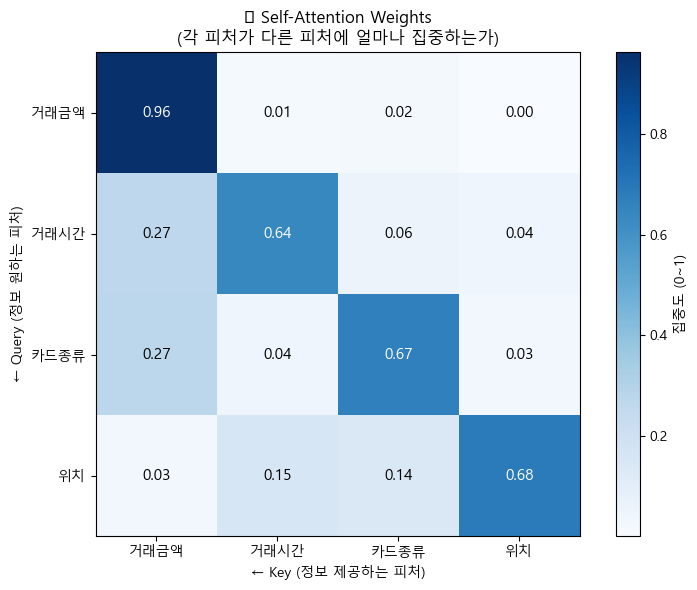


📖 히트맵 읽는 법:

1. 대각선이 높으면:
   → '자기 자신에 집중' (Self-Attention)
   → 예: 거래금액-거래금액 = 0.XX

2. 대각선 외에 높은 곳:
   → '다른 피처와 관련 있음'
   → 예: 거래금액-위치가 높으면
      '금액을 볼 때 위치도 중요하다'는 뜻!

3. FDS에서 이게 왜 유용?
   → 모델이 알아서 '관련있는 피처 조합' 학습
   → 사람이 일일이 피처 조합 안 만들어도 됨!


In [6]:
# ================================================================
# Attention Weights 시각화 (히트맵)
# ================================================================
#
# 히트맵 읽는 법:
# - 행(세로): Query 피처 = "내가 알고 싶은 것"
# - 열(가로): Key 피처 = "정보를 제공하는 것"
# - 색깔: 진할수록 "많이 집중"
#
# 예: (거래금액, 위치) = 0.40이면
#     "거래금액을 이해할 때 위치 정보를 40% 참고"
#

feature_names = ['거래금액', '거래시간', '카드종류', '위치']

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(attention_weights[0].detach().numpy(), cmap='Blues')

# 축 설정
ax.set_xticks(range(len(feature_names)))
ax.set_yticks(range(len(feature_names)))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

ax.set_xlabel('← Key (정보 제공하는 피처)')
ax.set_ylabel('← Query (정보 원하는 피처)')
ax.set_title('🔥 Self-Attention Weights\n(각 피처가 다른 피처에 얼마나 집중하는가)', fontsize=12)

# 숫자 표시
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        val = attention_weights[0, i, j].item()
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                color='white' if val > 0.3 else 'black', fontsize=11)

plt.colorbar(im, label='집중도 (0~1)')
plt.tight_layout()
plt.show()

# 해석 설명
print()
print("📖 히트맵 읽는 법:")
print("=" * 50)
print()
print("1. 대각선이 높으면:")
print("   → '자기 자신에 집중' (Self-Attention)")
print("   → 예: 거래금액-거래금액 = 0.XX")
print()
print("2. 대각선 외에 높은 곳:")
print("   → '다른 피처와 관련 있음'")
print("   → 예: 거래금액-위치가 높으면")
print("      '금액을 볼 때 위치도 중요하다'는 뜻!")
print()
print("3. FDS에서 이게 왜 유용?")
print("   → 모델이 알아서 '관련있는 피처 조합' 학습")
print("   → 사람이 일일이 피처 조합 안 만들어도 됨!")

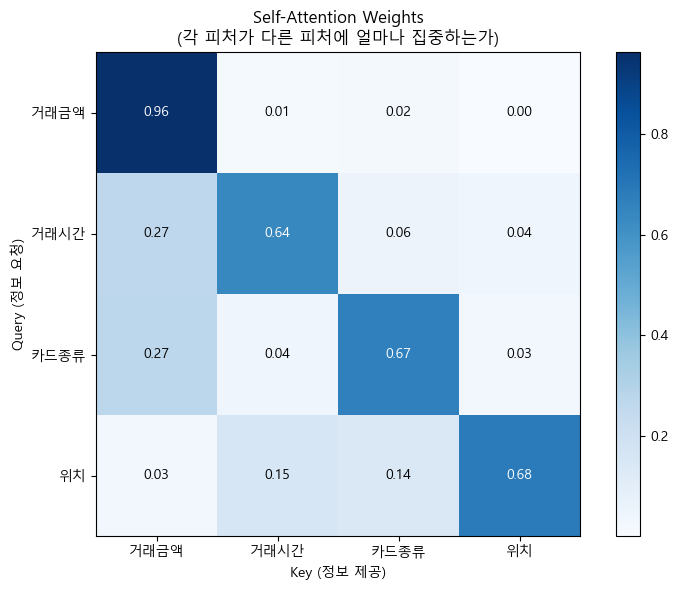


해석: 각 행은 Query 피처가 Key 피처들에 얼마나 집중하는지 보여줌
      대각선이 높으면 자기 자신에 집중 (Self-Attention)


In [7]:
# Attention Weights 시각화

feature_names = ['거래금액', '거래시간', '카드종류', '위치']

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(attention_weights[0].detach().numpy(), cmap='Blues')

ax.set_xticks(range(len(feature_names)))
ax.set_yticks(range(len(feature_names)))
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

ax.set_xlabel('Key (정보 제공)')
ax.set_ylabel('Query (정보 요청)')
ax.set_title('Self-Attention Weights\n(각 피처가 다른 피처에 얼마나 집중하는가)')

# 값 표시
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        val = attention_weights[0, i, j].item()
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                color='white' if val > 0.3 else 'black')

plt.colorbar(im)
plt.tight_layout()
plt.show()

print("\n해석: 각 행은 Query 피처가 Key 피처들에 얼마나 집중하는지 보여줌")
print("      대각선이 높으면 자기 자신에 집중 (Self-Attention)")

### 1-4. Multi-Head Attention

**문제:** 단일 Attention은 하나의 관점만 학습

**해결:** 여러 개의 Attention을 병렬로 (Multi-Head)

```
Head 1: "거래금액과 위치의 관계" 학습
Head 2: "거래시간과 카드종류의 관계" 학습
Head 3: "전체적인 패턴" 학습
...
→ 모든 Head 결과를 concat → 풍부한 표현
```

```python
# PyTorch에서
multihead_attn = nn.MultiheadAttention(embed_dim=64, num_heads=8)
```

---
## 3. TabTransformer (2020)

> ⚠️ **복잡한 코드가 나옵니다!**
> 
> 코드를 완벽히 이해할 필요 없습니다.
> **개념만 이해**하면 됩니다!

### 3-1. 핵심 아이디어 (한 문장)

> **"범주형 피처끼리 서로 어떤 관계인지 학습하자!"**

### 3-2. 왜 범주형만?

| 피처 종류 | 예시 | 특징 |
|----------|------|------|
| **범주형** | 카드종류, 국가, 브라우저 | 조합이 중요! |
| 수치형 | 금액, 시간 | 값 자체가 중요 |

```
예: 사기 패턴

카드=visa + 국가=해외 + 브라우저=익명 → 사기 확률 ↑↑

→ 범주형 피처들의 "조합"이 중요!
→ Transformer가 이런 조합을 자동으로 학습
```

### 3-3. 구조 (그림으로 이해)

```
입력 데이터:
├── 수치형: [금액=100만원, 시간=새벽3시]
└── 범주형: [카드=visa, 국가=해외, 브라우저=익명]

처리 과정:
┌────────────────────────────────────────────┐
│  수치형 피처들                              │
│  [금액, 시간]                               │
│      ↓                                      │
│  그대로 통과 ──────────────────┐            │
│                                │            │
│  범주형 피처들                  │            │
│  [카드, 국가, 브라우저]         │            │
│      ↓                         │            │
│  임베딩 (숫자로 변환)           │            │
│      ↓                         │            │
│  🔥 Transformer (관계 학습) 🔥  │            │
│      ↓                         │            │
│  새로운 표현 ─────────────────→│            │
│                                ↓            │
│              합치기 (Concat)                │
│                    ↓                        │
│                  MLP                        │
│                    ↓                        │
│               예측 (사기?)                  │
└────────────────────────────────────────────┘
```

### 3-4. 초보자를 위한 요약

1. **범주형 피처**만 Transformer에 넣음
2. Transformer가 **피처 간 관계** 학습 (예: visa+해외=위험)
3. 수치형 피처는 나중에 합침
4. MLP로 최종 예측

**면접 답변:**
> "TabTransformer는 범주형 피처에 Transformer를 적용해서
> 피처 간 상호작용을 학습합니다."

In [8]:
# ================================================================
# TabTransformer 구현
# ================================================================
#
# ⚠️ 이 코드를 완벽히 이해할 필요 없습니다!
#    개념만 이해하면 됩니다.
#
# 실제 프로젝트에서는 PyTorch Tabular 같은 라이브러리를 사용합니다.
# pip install pytorch-tabular
#

class TabTransformer(nn.Module):
    """
    TabTransformer: 범주형 피처에만 Transformer 적용
    
    흐름:
    1. 범주형 피처 → 임베딩 → Transformer
    2. 수치형 피처 → 그대로
    3. 합치기 → MLP → 예측
    """
    
    def __init__(self, num_categories, num_continuous, d_model=32, n_heads=4, n_layers=2):
        """
        Args:
            num_categories: 각 범주형 피처의 카테고리 수
                           예: [10, 5, 8] = 3개 범주형 피처
            num_continuous: 수치형 피처 수 (예: 5)
            d_model: 임베딩 차원 (보통 16~64)
            n_heads: Attention 헤드 수 (병렬 관점)
            n_layers: Transformer 레이어 수
        """
        super().__init__()
        
        self.num_categories = num_categories
        self.num_continuous = num_continuous
        self.d_model = d_model
        
        # ========================================
        # 1. 범주형 임베딩 (각 피처별로)
        # ========================================
        # 예: 카드종류(10개) → 32차원 벡터로 변환
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_cat, d_model) 
            for num_cat in num_categories
        ])
        
        # ========================================
        # 2. Transformer Encoder
        # ========================================
        # 범주형 피처들 간의 관계 학습
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,           # 임베딩 차원
            nhead=n_heads,             # 병렬 Attention 수
            dim_feedforward=d_model*4, # 내부 MLP 크기
            dropout=0.1,               # 과적합 방지
            batch_first=True           # (batch, seq, dim) 순서
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=n_layers
        )
        
        # ========================================
        # 3. MLP (최종 예측)
        # ========================================
        # Transformer 출력 + 수치형 피처 → 예측
        mlp_input_dim = len(num_categories) * d_model + num_continuous
        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, 64),  # 합친 것 → 64차원
            nn.ReLU(),                      # 활성화 함수
            nn.Dropout(0.1),                # 과적합 방지
            nn.Linear(64, 1),               # 64 → 1 (확률)
            nn.Sigmoid()                    # 0~1 사이로
        )
    
    def forward(self, x_cat, x_cont):
        """
        예측 수행
        
        Args:
            x_cat: 범주형 피처 (batch, 범주형 피처 수)
            x_cont: 수치형 피처 (batch, 수치형 피처 수)
        """
        # 1. 범주형 임베딩
        cat_embeds = []
        for i, embed in enumerate(self.embeddings):
            cat_embeds.append(embed(x_cat[:, i]))
        cat_embeds = torch.stack(cat_embeds, dim=1)
        
        # 2. Transformer (범주형 피처 간 관계 학습)
        transformed = self.transformer(cat_embeds)
        
        # 3. Flatten (펼치기)
        transformed = transformed.flatten(start_dim=1)
        
        # 4. 수치형 피처와 합치기
        combined = torch.cat([transformed, x_cont], dim=1)
        
        # 5. MLP로 예측
        out = self.mlp(combined)
        
        return out.squeeze(-1)

print("✅ TabTransformer 클래스 정의 완료!")
print()
print("💡 실제 사용할 때는 라이브러리 추천:")
print("   pip install pytorch-tabular")
print("   from pytorch_tabular.models import TabTransformerConfig")

✅ TabTransformer 클래스 정의 완료!

💡 실제 사용할 때는 라이브러리 추천:
   pip install pytorch-tabular
   from pytorch_tabular.models import TabTransformerConfig


In [9]:
# TabTransformer 간단 구현

class TabTransformer(nn.Module):
    """
    TabTransformer: 범주형 피처에 Transformer 적용
    
    Args:
        num_categories: 각 범주형 피처의 카테고리 수 리스트
        num_continuous: 수치형 피처 수
        d_model: 임베딩 차원
        n_heads: Multi-Head Attention 헤드 수
        n_layers: Transformer 레이어 수
    """
    
    def __init__(self, num_categories, num_continuous, d_model=32, n_heads=4, n_layers=2):
        super().__init__()
        
        self.num_categories = num_categories
        self.num_continuous = num_continuous
        self.d_model = d_model
        
        # 범주형 임베딩 (각 피처별로)
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_cat, d_model) for num_cat in num_categories
        ])
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # MLP (Transformer 출력 + 수치형 피처 → 예측)
        mlp_input_dim = len(num_categories) * d_model + num_continuous
        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x_cat, x_cont):
        """
        Args:
            x_cat: 범주형 피처 (batch, num_cat_features) - 정수 인덱스
            x_cont: 수치형 피처 (batch, num_cont_features) - 실수
        """
        # 1. 범주형 임베딩
        cat_embeds = []
        for i, embed in enumerate(self.embeddings):
            cat_embeds.append(embed(x_cat[:, i]))
        
        # (batch, num_cat_features, d_model)
        cat_embeds = torch.stack(cat_embeds, dim=1)
        
        # 2. Transformer (범주형 피처 간 관계 학습)
        transformed = self.transformer(cat_embeds)
        
        # 3. Flatten
        transformed = transformed.flatten(start_dim=1)
        
        # 4. Concat (Transformer 출력 + 수치형)
        combined = torch.cat([transformed, x_cont], dim=1)
        
        # 5. MLP
        out = self.mlp(combined)
        
        return out.squeeze(-1)

print("TabTransformer 클래스 정의 완료!")

TabTransformer 클래스 정의 완료!


---
## 4. FT-Transformer (2021)

### 4-1. TabTransformer의 아쉬운 점

```
TabTransformer:
- 범주형만 Transformer에 넣음
- 수치형은 나중에 그냥 합침
- 수치형 피처 간 관계는 학습 못함!
```

### 4-2. FT-Transformer의 해결책

> **"모든 피처를 Transformer에 넣자!"**

```
TabTransformer:  범주형만 → Transformer
FT-Transformer:  범주형 + 수치형 모두 → Transformer
```

### 4-3. 수치형 피처도 임베딩?

| 피처 타입 | TabTransformer | FT-Transformer |
|----------|----------------|----------------|
| 범주형 | 임베딩 테이블 | 임베딩 테이블 |
| 수치형 | 그대로 사용 | **Linear 변환** |

```
수치형 피처 임베딩:

금액 = 100만원
   ↓ Linear(1 → 32)
임베딩 = [0.3, -0.5, 0.8, ...]  (32차원)

→ 수치형도 범주형처럼 32차원 벡터로!
→ 이제 Transformer에 같이 넣을 수 있음
```

### 4-4. [CLS] 토큰이란?

BERT에서 가져온 아이디어:

```
입력: [금액, 시간, 카드, 위치]
     ↓ [CLS] 토큰 추가
입력: [[CLS], 금액, 시간, 카드, 위치]
     ↓ Transformer
출력: [[CLS]', 금액', 시간', 카드', 위치']
            ↑
     이것만 사용해서 예측!
```

**[CLS]의 역할:**
- 모든 피처 정보를 "요약"
- 예측할 때 이것만 보면 됨

### 4-5. 구조 비교

| 요소 | TabTransformer | FT-Transformer |
|------|----------------|----------------|
| 수치형 처리 | MLP에서 | **Transformer에서** |
| 범주형 처리 | Transformer | Transformer |
| 출력 방식 | Flatten | **[CLS] 토큰** |
| 성능 | 좋음 | **더 좋음** |
| 복잡도 | 보통 | 높음 |

### 4-6. 초보자를 위한 요약

1. **모든 피처**를 Transformer에 넣음
2. 수치형도 **Linear 변환**으로 임베딩
3. **[CLS] 토큰**으로 전체 정보 요약
4. 성능은 좋지만 더 복잡함

**면접 답변:**
> "FT-Transformer는 모든 피처를 Transformer로 처리해서
> 수치형 피처 간 관계도 학습합니다. [CLS] 토큰으로 예측합니다."

In [10]:
# ================================================================
# FT-Transformer 구현
# ================================================================
#
# ⚠️ 이 코드도 완벽히 이해할 필요 없습니다!
#    TabTransformer와의 차이점만 파악하면 됩니다.
#
# 차이점:
# 1. 수치형 피처도 임베딩 (Linear 변환)
# 2. [CLS] 토큰 추가
# 3. [CLS] 출력으로 예측
#

class FTTransformer(nn.Module):
    """
    FT-Transformer: 모든 피처에 Transformer 적용
    
    TabTransformer와 차이:
    - 수치형도 Linear로 임베딩
    - [CLS] 토큰으로 예측
    """
    
    def __init__(self, num_categories, num_continuous, d_model=32, n_heads=4, n_layers=2):
        super().__init__()
        
        self.num_categories = num_categories
        self.num_continuous = num_continuous
        self.d_model = d_model
        
        # ========================================
        # 1. 범주형 임베딩 (TabTransformer와 동일)
        # ========================================
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(num_cat, d_model) 
            for num_cat in num_categories
        ])
        
        # ========================================
        # 2. 수치형 임베딩 (FT-Transformer의 핵심!)
        # ========================================
        # 각 수치형 피처를 Linear로 d_model 차원으로 변환
        # 예: 금액(1차원) → Linear → 32차원 벡터
        self.cont_embeddings = nn.ModuleList([
            nn.Linear(1, d_model) 
            for _ in range(num_continuous)
        ])
        
        # ========================================
        # 3. [CLS] 토큰 (학습되는 파라미터)
        # ========================================
        # 모든 피처 정보를 "요약"하는 특별한 토큰
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # ========================================
        # 4. Transformer Encoder
        # ========================================
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=n_layers
        )
        
        # ========================================
        # 5. 출력 레이어 ([CLS] → 예측)
        # ========================================
        self.output = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x_cat, x_cont):
        batch_size = x_cat.size(0)
        
        # 1. 범주형 임베딩
        cat_embeds = [
            embed(x_cat[:, i]) 
            for i, embed in enumerate(self.cat_embeddings)
        ]
        
        # 2. 수치형 임베딩 (FT-Transformer 핵심!)
        cont_embeds = [
            embed(x_cont[:, i:i+1])  # (batch, 1) → (batch, d_model)
            for i, embed in enumerate(self.cont_embeddings)
        ]
        
        # 3. 모든 임베딩 결합
        all_embeds = cat_embeds + cont_embeds
        tokens = torch.stack(all_embeds, dim=1)
        
        # 4. [CLS] 토큰 추가 (맨 앞에)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat([cls_tokens, tokens], dim=1)
        
        # 5. Transformer
        transformed = self.transformer(tokens)
        
        # 6. [CLS] 출력만 사용 (첫 번째 토큰)
        cls_output = transformed[:, 0]
        
        # 7. 예측
        out = self.output(cls_output)
        
        return out.squeeze(-1)

print("✅ FT-Transformer 클래스 정의 완료!")
print()
print("TabTransformer와 차이점:")
print("  1. 수치형도 Linear로 임베딩")
print("  2. [CLS] 토큰 추가")
print("  3. [CLS] 출력으로 예측")

✅ FT-Transformer 클래스 정의 완료!

TabTransformer와 차이점:
  1. 수치형도 Linear로 임베딩
  2. [CLS] 토큰 추가
  3. [CLS] 출력으로 예측


In [11]:
# FT-Transformer 간단 구현

class FTTransformer(nn.Module):
    """
    FT-Transformer: 모든 피처에 Transformer 적용
    
    Args:
        num_categories: 각 범주형 피처의 카테고리 수 리스트
        num_continuous: 수치형 피처 수
        d_model: 임베딩 차원
        n_heads: Multi-Head Attention 헤드 수
        n_layers: Transformer 레이어 수
    """
    
    def __init__(self, num_categories, num_continuous, d_model=32, n_heads=4, n_layers=2):
        super().__init__()
        
        self.num_categories = num_categories
        self.num_continuous = num_continuous
        self.d_model = d_model
        
        # 범주형 임베딩
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(num_cat, d_model) for num_cat in num_categories
        ])
        
        # 수치형 Feature Tokenizer (각 피처별 Linear)
        self.cont_embeddings = nn.ModuleList([
            nn.Linear(1, d_model) for _ in range(num_continuous)
        ])
        
        # [CLS] 토큰
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # 출력 레이어 ([CLS] 토큰 → 예측)
        self.output = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x_cat, x_cont):
        """
        Args:
            x_cat: 범주형 피처 (batch, num_cat_features)
            x_cont: 수치형 피처 (batch, num_cont_features)
        """
        batch_size = x_cat.size(0)
        
        # 1. 범주형 임베딩
        cat_embeds = [embed(x_cat[:, i]) for i, embed in enumerate(self.cat_embeddings)]
        
        # 2. 수치형 임베딩 (Feature Tokenizer)
        cont_embeds = [
            embed(x_cont[:, i:i+1]) for i, embed in enumerate(self.cont_embeddings)
        ]
        
        # 3. 모든 임베딩 결합
        all_embeds = cat_embeds + cont_embeds
        tokens = torch.stack(all_embeds, dim=1)  # (batch, num_features, d_model)
        
        # 4. [CLS] 토큰 추가
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        tokens = torch.cat([cls_tokens, tokens], dim=1)  # (batch, 1+num_features, d_model)
        
        # 5. Transformer
        transformed = self.transformer(tokens)
        
        # 6. [CLS] 토큰 출력만 사용
        cls_output = transformed[:, 0]  # (batch, d_model)
        
        # 7. 예측
        out = self.output(cls_output)
        
        return out.squeeze(-1)

print("FT-Transformer 클래스 정의 완료!")

FT-Transformer 클래스 정의 완료!


---
## 5. 트리 모델 vs Transformer

### 5-1. 결론부터! (중요)

> **정형 데이터에서는 트리 모델이 아직 더 좋습니다!**
> 
> ⚠️ 하지만 **시계열 데이터는 다릅니다!** (아래 5-7 참고)

### 5-2. 2024-2025 벤치마크 결과

**"Why do tree-based models still outperform deep learning on tabular data?"**

| 데이터 크기 | 승자 | 이유 |
|------------|------|------|
| **작은 데이터 (<10K)** | 🌳 트리 | DL은 과적합됨 |
| **중간 데이터 (10K-100K)** | 🌳≈🤖 비슷 | 상황마다 다름 |
| **큰 데이터 (>100K)** | 🤖 DL 유리 | 충분히 학습 가능 |

### 5-3. 비유: 운전 초보 vs 베테랑

```
트리 모델 = 운전 초보에게 자동차
- 바로 잘 달림
- 특별한 기술 필요 없음
- 연료(데이터) 적게 들어도 OK

Transformer = 운전 초보에게 F1 레이싱카
- 잠재력은 높음
- 하지만 다루기 어려움
- 연료(데이터) 많이 필요
```

### 5-4. 언제 뭘 쓸까?

| 상황 | 추천 모델 | 이유 |
|------|----------|------|
| 데이터 < 10만 | 🌳 트리 | DL 과적합 위험 |
| 실시간 추론 필요 | 🌳 트리 | 5ms vs 50ms+ |
| 설명 필요 (규제) | 🌳 트리 | SHAP 지원 |
| 데이터 > 100만 | 🤖 Transformer | 충분한 학습 |
| 복잡한 피처 관계 | 🤖 Transformer | Attention 학습 |

### 5-5. 우리 FDS 프로젝트에서는?

| 요소 | 우리 상황 | 결론 |
|------|----------|------|
| 데이터 크기 | 59만 건 | 트리도 OK, DL도 가능 |
| 추론 속도 | **실시간 필요** | 🌳 트리 유리 |
| 해석 가능성 | **금융 규제** | 🌳 트리 유리 (SHAP) |
| 현재 성능 | AUC 0.92 | 충분히 좋음 |

**최종 결정:**
> 트리 스태킹 (XGBoost + LightGBM + CatBoost) 사용!
> Transformer는 **실험 목적**으로만 시도

---

### 5-6. 면접에서 이렇게 답하세요

**Q: "왜 Transformer 안 썼어요?"**

> "세 가지 이유입니다:
> 1. **추론 속도**: 실시간 FDS에서 트리(5ms)가 Transformer(50ms+)보다 빠름
> 2. **해석 가능성**: 금융 규제로 SHAP 설명 필요 - 트리가 적합
> 3. **성능**: 59만 건에서 트리 스태킹이 충분히 좋은 성능
>
> Transformer 실험도 해봤지만, 트리가 더 적합했습니다."

---

### 5-7. ⚠️ 잠깐! 시계열이면 다르다!

> **여기까지는 "정형(Static) 데이터" 기준이었습니다.**
> 
> 금융 데이터가 시계열 아니냐고요? 맞습니다!
> 하지만 **데이터 형태**에 따라 다릅니다.

#### 정형 vs 시계열 구분

| 데이터 타입 | 예시 | 특징 | 승자 |
|------------|------|------|------|
| **정형 (Static)** | 한 거래의 특성 (금액, 카드, 위치) | 순서 없음 | 🌳 트리 |
| **시계열 (Sequential)** | 거래 히스토리 [거래1→거래2→...] | **순서 중요!** | 🤖 LSTM/Transformer |

#### Stripe 성공 사례 🚀

```
Stripe Payments Foundation Model:
├── 수십억 거래 시퀀스로 Transformer 학습
├── 탐지율: 59% → 97% (38%p 향상!)
└── 이전에 놓쳤던 순차적 사기 패턴 탐지

→ 시계열에서는 Transformer가 훨씬 강력!
```

#### 그럼 우리 IEEE-CIS 데이터는?

```
IEEE-CIS 데이터의 한계:
├── V1~V339: PCA 변환된 정적 피처
├── 거래별 독립 (사용자 히스토리 없음)
└── 시간 순서로 연결되지 않음

→ 정형 데이터에 가까움
→ 그래서 LSTM이 효과 없었음 (AUC 0.70)
→ 트리 모델이 적합한 이유!
```

#### 진짜 시계열 FDS라면?

```
PaySim, Stripe 같은 데이터:
├── 사용자별 거래 시퀀스 존재
├── [거래1] → [거래2] → ... → [현재 거래]
└── 패턴: "갑자기 해외 거래 5건 연속"

→ LSTM, Transformer가 유리!
→ 긴 시퀀스일수록 Transformer가 더 좋음
```

#### 면접 추가 Q&A

**Q: "시계열 사기 탐지에서도 트리가 좋나요?"**

> "아닙니다! **시계열에서는 LSTM이나 Transformer가 유리**합니다.
> Stripe는 Transformer로 탐지율을 59%에서 97%로 높였습니다.
>
> 하지만 우리 IEEE-CIS 데이터는 거래별 독립적인 **정형 데이터**라서
> 트리 모델이 더 적합했습니다. 
>
> PaySim 같은 **시퀀스 데이터**에서는 LSTM/Transformer가 더 좋을 것입니다."

**Q: "LSTM이 왜 안 됐나요?"**

> "IEEE-CIS 데이터는 **진짜 시퀀스가 아니기 때문**입니다.
> V1~V339가 PCA 변환된 정적 피처여서, 시간 순서 정보가 없습니다.
> 
> LSTM은 순서가 중요한 시퀀스 데이터에서 강점이 있는데,
> 우리 데이터는 각 거래가 독립적이라 LSTM의 장점을 못 살렸습니다."

---
## 5. 트리 모델 vs Transformer

### 5-1. 2024-2025 벤치마크 결과

**"Why do tree-based models still outperform deep learning on typical tabular data?"**

| 데이터 크기 | 승자 | 이유 |
|------------|------|------|
| **작은 데이터 (<10K)** | 트리 | DL은 과적합 |
| **중간 데이터 (10K-100K)** | 트리 ≈ DL | 비슷 |
| **큰 데이터 (>100K)** | DL 유리 | 충분한 학습 |

### 5-2. 언제 Transformer가 유리한가?

1. **대규모 데이터** (100K+ 샘플)
2. **피처 간 복잡한 상호작용**이 있을 때
3. **범주형 피처가 많을 때**
4. **Semi-supervised Learning** 가능할 때

### 5-3. 트리가 유리한 경우

1. **작은/중간 데이터**
2. **해석 가능성** 중요
3. **빠른 추론** 필요
4. **튜닝 시간** 제한

### 5-4. FDS에서의 선택

| 요소 | 분석 | 결론 |
|------|------|------|
| 데이터 크기 | 590K | Transformer 가능 |
| 추론 속도 | 실시간 필요 | 트리 유리 |
| 해석 가능성 | 규제 요구 | 트리 유리 (SHAP) |
| **최종** | - | **트리 스태킹 + Transformer 실험** |

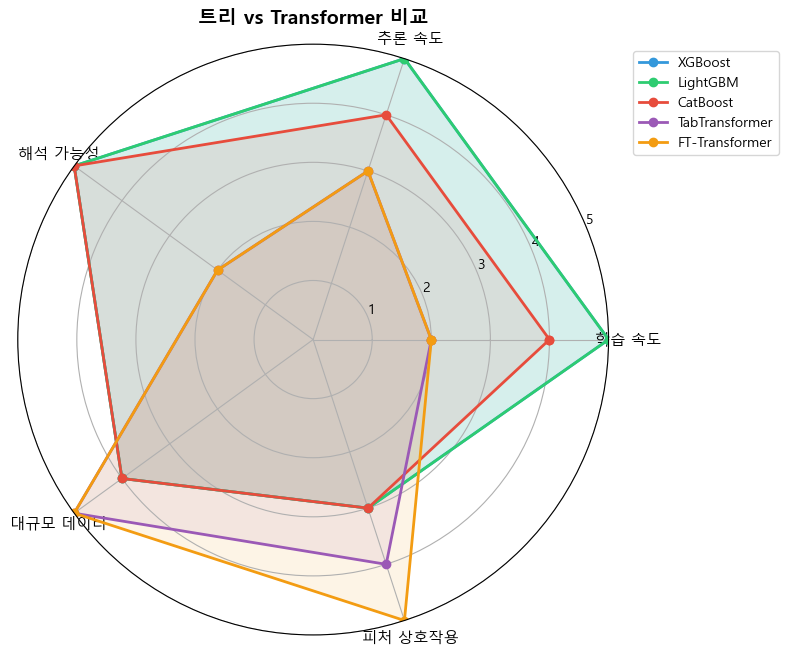


결론:
  - 트리: 속도, 해석 가능성에서 우위
  - Transformer: 대규모 데이터, 피처 상호작용에서 우위
  - FDS에서는 트리 스태킹이 현실적 선택 (실시간 + SHAP)


In [12]:
# 트리 vs Transformer 비교 시각화

comparison_data = {
    '모델': ['XGBoost', 'LightGBM', 'CatBoost', 'TabTransformer', 'FT-Transformer'],
    '학습 속도': [5, 5, 4, 2, 2],
    '추론 속도': [5, 5, 4, 3, 3],
    '해석 가능성': [5, 5, 5, 2, 2],
    '대규모 데이터': [4, 4, 4, 5, 5],
    '피처 상호작용': [3, 3, 3, 4, 5]
}

df_compare = pd.DataFrame(comparison_data)
df_compare = df_compare.set_index('모델')

# Radar Chart
categories = list(df_compare.columns)
N = len(categories)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # 닫기

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

for idx, model in enumerate(df_compare.index):
    values = df_compare.loc[model].values.flatten().tolist()
    values += values[:1]  # 닫기
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 5)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.set_title('트리 vs Transformer 비교', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n결론:")
print("  - 트리: 속도, 해석 가능성에서 우위")
print("  - Transformer: 대규모 데이터, 피처 상호작용에서 우위")
print("  - FDS에서는 트리 스태킹이 현실적 선택 (실시간 + SHAP)")

---
## 면접 Q&A

### Q: "Self-Attention이 뭔가요?"

> "입력 시퀀스의 각 요소가 다른 모든 요소와의 관계를 학습하는 메커니즘입니다.
> Query, Key, Value를 통해 '어디에 집중할지'를 학습합니다.
> 정형 데이터에서는 각 피처가 다른 피처와의 상호작용을 학습합니다."

### Q: "TabTransformer와 FT-Transformer의 차이는?"

> "TabTransformer는 **범주형 피처만** Transformer로 처리하고, 수치형은 MLP에서 처리합니다.
> FT-Transformer는 **모든 피처**를 Transformer로 처리합니다.
> FT-Transformer가 성능이 더 좋지만, 파라미터가 더 많습니다."

### Q: "정형 데이터에서 Transformer가 트리보다 항상 좋나요?"

> "아닙니다. 2024-2025 벤치마크에서 **작은/중간 데이터에서는 트리가 여전히 우위**입니다.
> Transformer는 100K+ 대규모 데이터, 복잡한 피처 상호작용이 있을 때 유리합니다.
> 또한 트리는 추론 속도가 빠르고 SHAP으로 해석 가능해서 실시간 FDS에 적합합니다."

### Q: "FDS에서 Transformer를 왜 안 썼나요?"

> "세 가지 이유입니다:
> 1. **추론 속도**: 트리(5ms) vs Transformer(50ms+) - 실시간 필요
> 2. **해석 가능성**: 금융 규제로 SHAP 설명 필요 - 트리가 적합
> 3. **성능**: 59만 건에서 트리 스태킹(AUPRC 0.60, AUC 0.92)이 충분히 높음
>
> 다만 Transformer 실험(1-10)으로 비교는 해볼 계획입니다."

### Q: "Positional Encoding이 정형 데이터에서 왜 불필요한가요?"

> "NLP에서 Positional Encoding은 **단어의 순서** 정보를 제공합니다.
> 정형 데이터에서 피처는 **순서가 없습니다** - [금액, 시간] ≡ [시간, 금액]
> 따라서 Positional Encoding을 추가하면 오히려 불필요한 바이어스가 생깁니다."

### Q: "Transformer가 실제 금융권에서 사용되나요?"

> "네, 일부 기업에서 production 사용 중입니다:
> - **Booking.com**: FT-Transformer로 사기 탐지
> - **Stripe**: Transformer 기반 fraud detection
> - **Mastercard**: RAG 기반 scam detection (2024)
>
> 다만 **XGBoost가 여전히 주류**입니다 - 속도(5ms vs 50ms+)와 SHAP 해석성 때문입니다."

In [ ]:
print("=" * 60)
print("  🎉 1-S10 완료: Transformer for Tabular Data")
print("=" * 60)
print()
print("📚 오늘 배운 것 (초보자 버전):")
print()
print("1️⃣ 임베딩 (Embedding)")
print("   → 문자를 숫자 벡터로 변환")
print("   → 비슷한 것은 비슷한 숫자!")
print()
print("2️⃣ Self-Attention")
print("   → '어디에 집중할지' 자동 학습")
print("   → Q(질문), K(키워드), V(정보)")
print("   → 카페 주문, 도서관 검색 비유")
print()
print("3️⃣ TabTransformer")
print("   → 범주형 피처에만 Transformer 적용")
print("   → 수치형은 나중에 합침")
print()
print("4️⃣ FT-Transformer")
print("   → 모든 피처에 Transformer 적용")
print("   → [CLS] 토큰으로 예측")
print()
print("5️⃣ 트리 vs Transformer (가장 중요!)")
print("   → 정형 데이터: 아직 트리가 더 좋음")
print("   → FDS: 속도 + 해석 → 트리 선택")
print()
print("=" * 60)
print("💡 면접에서 기억할 것:")
print("=" * 60)
print()
print("Q: Self-Attention이 뭔가요?")
print("A: 어디에 집중할지 자동으로 학습하는 메커니즘입니다.")
print()
print("Q: 왜 Transformer 안 썼어요?")
print("A: 속도(5ms vs 50ms+), 해석성(SHAP), 성능(AUC 0.92)으로 트리 선택")
print()
print("Q: Transformer가 더 좋은 경우는?")
print("A: 데이터 100만+, 복잡한 피처 관계, 충분한 학습 시간")
print()
print("=" * 60)
print("다음: 1-10 Transformer 구현 실험 (선택)")
print("=" * 60)

In [ ]:
print("=" * 60)
print("  1-S10 완료: Transformer for Tabular Data")
print("=" * 60)
print()
print("배운 것:")
print()
print("1. Self-Attention")
print("   - Query, Key, Value로 '어디에 집중할지' 학습")
print("   - Multi-Head: 여러 관점에서 관계 학습")
print()
print("2. 정형 데이터에서 Transformer")
print("   - Column Embedding: 피처를 토큰처럼 취급")
print("   - Positional Encoding 불필요 (순서 없음)")
print()
print("3. TabTransformer")
print("   - 범주형 피처만 Transformer 적용")
print("   - 수치형은 MLP에서 처리")
print()
print("4. FT-Transformer")
print("   - 모든 피처를 Transformer로 처리")
print("   - [CLS] 토큰으로 예측")
print()
print("5. 트리 vs Transformer")
print("   - 작은/중간 데이터: 트리 우위")
print("   - 대규모 데이터: Transformer 유리")
print("   - FDS: 트리 스태킹 선택 (속도 + 해석)")
print()
print("=" * 60)
print("다음: 1-10 Transformer 구현 (선택)")
print("=" * 60)